In [ ]:
%pip install svetlanna
%pip install reservoirpy matplotlib tqdm requests av scikit-image py-cpuinfo gputil pandas

In [ ]:
DEVICE = 'cpu'

### Imports

In [1]:
import os
import sys
import random

In [2]:
import time
import json

In [3]:
import warnings
warnings.simplefilter("always")

In [4]:
import numpy as np

In [5]:
from collections import Counter

In [6]:
import torch
from torch.utils.data import Dataset

In [7]:
from torch import nn

In [8]:
from torch.nn import functional

In [9]:
import torchvision
import torchvision.transforms as transforms

In [10]:
from torchvision.transforms import InterpolationMode

In [11]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [12]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.detector import Detector, DetectorProcessorClf

In [13]:
from svetlanna.transforms import ToWavefront

In [14]:
# Weizmann dataset
from src_weizmann.weizmann import download_weizmann, download_weizmann_masks
from src_weizmann.weizmann import PERSONS, ACTIONS, DESCRIPTIONS

In [15]:
from tqdm import tqdm

In [16]:
from datetime import datetime

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# Diffractive Recurrent Neural Network (D-RNN)

In that notebook we realized a recurrent architecture proposed in the article [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4) for [the Weizmann dataset](https://www.wisdom.weizmann.ac.il/~vision/SpaceTimeActions.html).

#### <span style="color:red">Methods </span> [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4)



In [18]:
today_date = datetime.today().strftime('%d-%m-%Y_%H-%M')  # date for a results folder name
today_date

'28-02-2025_16-42'

In [19]:
# Define all necessery variables for that notebook
VARIABLES = {
    # FILEPATHES
    'data_path': 'data/weizmann',  # folder which will be created (if not exists) to load/store Weizmann dataset
    'results_path': f'models/reproduced_results/weizmann_exp_{today_date}',  # filepath to save results!
    
    # GENERAL SETTINGS - SECTION 1 of the notebook
    'wavelength': 750 * 1e-6,  # working wavelength, in [m]
        # Comment: Value from the article [1] - 698 * 1e-9  # in [m]
    'neuron_size': 400 * 1e-6,  # size of a pixel for DiffractiveLayers, in [m]
        # Comment: Value from the article [1] - 9.2 * 1e-6  # in [m]
    'mesh_size': (400, 400),  # full size of a layer = numerical mesh
        # Comment: value from the article [1] - (700, 700)
    'use_apertures': True,  # if we need to add apertures before each Diffractie layer
        # Comment: value from the article [1] - unknown
    'aperture_size': (200, 200),  # size of each aperture = a detector square for classes zones
        # Comment: value from the article [1] - unknown
    
    # DATASET OF SUBSEQUENCES SETTINGS - SECTION 2 of the notebook
    'sequence_len': 3,  # each video will be splitted into subsequences of this length (see Subsec. 2.2.)
        # Comment: value from the article [1] - 3
    'skip_between_frames': 2,  # it is a skip between timesteps in sequences
        # Comment: value from the article [1] - 2
    'modulation': 'amp',  # modulation type to make a wavefront from each frame mask (see 2.3.2.)
        # Comment: cam be equal to `phase`, `amp` or `both`
        # Comment: value from the article [1] - 'amp'
    'augmentation_flip': True,  # if True uses a horizontal flip to make a dataset twice as large (see 2.3.3.)
        # Comment: value from the article [1] - True

    'center_silhouettes': True,  # if True - every silhouette placed in a center of wavefront!
        # Comment: According to [1] and a provided phase mask for a read-in layer
        #          we concluded that authors did so!
        # Comment: see beginning of Section 2!
        # Comment: value from the article [1] - True  # more likely!
    'exclude_cutted_silhouettes': True,  # see beginning of Section 2!
        # Comment: Some frames are cutted because for some actions a person appears within 
        #          a frame and goes to the opposite boundary! 
        # Criterias to exclude a frame because of a part of a silhouette is out of frame:
        # 1. one of boundaries of a silhouette bounding box coincides with a boundary of a frame;
        # 2. if 1^st criteria satisfied and a width of a silhouette bounding box is less than some value

    # DETECTOR ZONES
    'detector_segment_size': 12 * 750 * 1e-6,  # size of each square class zone on a detector, in [m]
        # Comment: value from the article [1] - 0.46 * 1e-3  # [m]

    # RECURRENT OPTICAL NETWORK - SECTION 3 of the notebook
    'fusing_coefficient': 0.2,  # value responsible for memorising (see 3.1.1.)
        # Comment: value from the article [1] - 0.2  # best value according to Supplementary of [1]
    'max_phase': 2 * torch.pi,  # maximal possible phase for each DiffractiveLayer
        # Comment: value from the article [1] - 2 * torch.pi
    'init_phase': torch.pi,  # initial constant phases for DiffractiveLayers
        # Comment: value from the article [1] - torch.pi
    'free_space_method': 'AS',  # propagation method
        # Comment: value from the article [1] - 'AS'
    'free_space_distance': 9 * 1e-2,  # constant free space distance for a network, in [m]
        # Comment: for now all free spaces are of the same size!
        # Comment: value from the article [1] - 20 * 1e-2  # [m] - not clear what size is it...
    'read_in_freespace': False,  
        # if True adds a FreeSpace between an image and Diffractive layer in read-in layer
        # Comment: According to [1] and a provided phase mask for a read-in layer
        #          we concluded that authors didn't use FreeSpace at the beginning of read-in layer!
    'use_nonlinear_layers': (True, False, False),  # nonliner layers: amp -> amp ** 2
        # flags for adding nonlinear layers after DiffractiveLayers in RNN Layers (see 3.1.2. - 3.1.3.)
        # Comment: each bool is respobsible for each RNN Layr: (read-in, memory, read-out)
        # Comment: for now there are same nonlinearities (~x^2) after DiffractiveLayers in corresponding RNN layers!
    'weighted_detector_zones': True,  # if True - uses weights for detector zones in DetectorProcessor (see 2.3.2.)
        # Comment: it is important because of classes imbalance!
        # Comment: Weights will be used to calculate integrals over detector classes zones!
        # Comment: Not realized properly for MSE...
    
    # OPTICAL NETWORK LEARNING - SECTION 4 of the notebook
    'loss': 'CE',  # support only MSEloss (`MSE`) and CrossEnthropyLoss (`CE`) (see 3.1.4.)
        # Comment: it is also influence on validation/training loops!!!
    'calculate_accuracies': True,  # will be always True for CrossEnthropyLoss! (see 3.1.4.)
    'DEVICE': DEVICE,  # if `cuda` - we will check if it is available (see first cells of Sec. 4)
    'train_batch_size': 10,  # batch sizes for training (see 4.1.1.)
    'val_batch_size': 20,
        # Comment: value from the article [1] - 20  # for both train and test?
    'adam_lr': 0.01,  # learning rate for Adam optimizer (see 4.1.2.)
        # Comment: value from the article [1] - 0.01
    'number_of_epochs': 15,  # number of epochs to train
        # Comment: value from the article [1] - 15  # (?)
}

In [20]:
RESULTS_FOLDER = VARIABLES['results_path']

if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [21]:
RESULTS_FOLDER

'models/reproduced_results/weizmann_exp_28-02-2025_16-42'

In [22]:
# save experiment conditions (VARIABLES dictionary)
with open(f'{RESULTS_FOLDER}/conditions.json', 'w', encoding ='utf8') as json_file:
    json.dump(VARIABLES, json_file, ensure_ascii = True)

# 1. Simulation parameters

Citations from methods of [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> ...  working wavelength of $698$ nm ...

> ... we optimized and set the number of input nodes and optoelectronic neurons of the DPU as ... $700 \times 700$ for the D-RNN (Supplementary Fig. 6), each with a size of $9.2$ μm, during both the training and testing.

**<span style="color:red">Comment.</span>** We will try to use dimensions like for MNIST by Ozcan!

In [23]:
working_wavelength = VARIABLES['wavelength']  # [m] - like for MNIST

c_const = 299_792_458  # [m / s]
working_frequency = c_const / working_wavelength # [Hz]

In [24]:
print(f'lambda    = {working_wavelength * 1e9:.3f} nm')
print(f'frequency = {working_frequency / 1e12:.3f} THz')

lambda    = 750000.000 nm
frequency = 0.400 THz


In [25]:
# neuron size (square)
neuron_size = VARIABLES['neuron_size']  # [m] - like for MNIST
print(f'neuron size = {neuron_size * 1e6:.3f} um')

neuron size = 400.000 um


In [26]:
APERTURES = VARIABLES['use_apertures']  # add apertures BEFORE each diffractive layer or not

In [27]:
LAYER_SIZE = VARIABLES['mesh_size']  # mesh size
DETECTOR_SIZE = VARIABLES['aperture_size']

**<span style="color:red">Comment.</span>** Detector size is also used for apertures!

In [28]:
# number of neurons in simulation
x_layer_nodes = LAYER_SIZE[1]
y_layer_nodes = LAYER_SIZE[0]
# Comment: Same size as proposed!

print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (in neurons): 400 x 400 = 160000


Citations from methods of [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> Therefore, the network size at each layer is ... $6.44 \times 6.44$ mm for the D-RNN.

In [29]:
# physical size of each layer
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Layer size (in mm): {x_layer_size_m * 1e3 :.3f} x {y_layer_size_m * 1e3 :.3f}')

Layer size (in mm): 160.000 x 160.000


In [30]:
# simulation parameters for the rest of the notebook

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Dataset preparation

## Load data

> The extracted masks obtained by background subtraction: the file (Matlab 7 format, ~1700KB) contains both the original masks as well as the aligned ones (that were the actual inputs to our algorithm).

<span style="color:red">**Comment:**</span> All masks are of the shape $64 \times 64$.

In [31]:
WEIZMANN_DIR = VARIABLES['data_path']

#### Load masks

In [32]:
# uncomment to download masks:
download_weizmann_masks(dest=WEIZMANN_DIR)

Saving masks for `bend` as .npy to `data/weizmann/bend_masks`... Done!
Saving masks for `jack` as .npy to `data/weizmann/jack_masks`... Done!
Saving masks for `jump` as .npy to `data/weizmann/jump_masks`... Done!
Saving masks for `pjump` as .npy to `data/weizmann/pjump_masks`... Done!
Saving masks for `run` as .npy to `data/weizmann/run_masks`... Done!
Saving masks for `side` as .npy to `data/weizmann/side_masks`... Done!
Saving masks for `skip` as .npy to `data/weizmann/skip_masks`... Done!
Saving masks for `walk` as .npy to `data/weizmann/walk_masks`... Done!
Saving masks for `wave1` as .npy to `data/weizmann/wave1_masks`... Done!
Saving masks for `wave2` as .npy to `data/weizmann/wave2_masks`... Done!


#### Actions labels

In [33]:
NUM_ACTIONS = len(ACTIONS)

In [34]:
ID_TO_ACTION = {idx: act for idx, act in enumerate(ACTIONS)}
ACTION_TO_ID = {act: idx for idx, act in ID_TO_ACTION.items()}
ACTION_TO_ID

{'bend': 0,
 'jack': 1,
 'jump': 2,
 'pjump': 3,
 'run': 4,
 'side': 5,
 'skip': 6,
 'walk': 7,
 'wave1': 8,
 'wave2': 9}

In [35]:
# save id to action dict!
with open(f'{RESULTS_FOLDER}/id2action.json', 'w', encoding ='utf8') as json_file:
    json.dump(ID_TO_ACTION, json_file, ensure_ascii = True)

## 2.1. Train and Test data 

Citations from methods of [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):


> We adopted the actions from six subjects ($60$ video sequences) as the training set, with the rest of the actions, that is, three subjects ($30$ video sequences), as the test set.

<span style="color:red">**Comment:**</span> Do we need to select videos for each action by persons or not?

In [36]:
# we need to select 6 videos of each action for train 

np.random.seed(78)
seed_for_each_action = np.random.randint(
    low=0, high=100, 
    size=len(ACTIONS), 
)  # random seed to select 6 out of 9 videos for each action
#  RATIOS: test / train = 1 / 2, train / all = 2 / 3
n_files_of_each_action = 9  # all files in each action folder
n_train = 6

all_files = []
all_train_files = []  # files which will be used as train data
all_test_files = []   # files which will be used as test data

for ind, act_this in enumerate(ACTIONS):
    dir_this = os.path.join(WEIZMANN_DIR, f'{act_this}_masks')
    lisdir_this = [fn for fn in os.listdir(dir_this) if fn[-3:] == 'npy']
    
    np.random.seed(seed_for_each_action[ind])  # seed for the action to select 6 files
    train_ids = np.random.choice(n_files_of_each_action, n_train, replace=False)
    
    for ind_file, filepath in enumerate(lisdir_this):
        all_files.append(os.path.join(dir_this, filepath))
        
        if ind_file in train_ids:
            all_train_files.append(os.path.join(dir_this, filepath))
        else:
            all_test_files.append(os.path.join(dir_this, filepath))

In [37]:
print(f'Train files: {len(all_train_files)}')
print(f'Test  files: {len(all_test_files)}')

Train files: 60
Test  files: 30


In [38]:
with open(f'{RESULTS_FOLDER}/train_files.txt', 'w') as file:
    for filepath_this in all_train_files:
        file.write(f'{filepath_this}\n')

with open(f'{RESULTS_FOLDER}/test_files.txt', 'w') as file:
    for filepath_this in all_test_files:
        file.write(f'{filepath_this}\n')

In [39]:
print(f'All files: {len(all_files)}')

All files: 90


## 2.2. Data sequencing 

Citations from methods of [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> ... each video was divided into numbers of sub-sequences by sequentially extracting three frames for each sub-sequence with a frame interval of two.

In [40]:
NETWORK_SEQ = VARIABLES['sequence_len']
SKIP = VARIABLES['skip_between_frames']  # it is a skip between timesteps in sequences

## 2.3. Dataset construction

#### <span style="color:red">Data augmentation</span>

Citations from methods of [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> After the data augmentation (horizontally flip), the total numbers of sub-sequences in the training and test sets of the Weizmann database were $6,000$ and $3,000$, respectively.

> ... the network sequence lengths were set to 3 ... for the Weizmann ...

In [41]:
INIT_MASK_SIZE = 64  # each loaded mask is of the shape 64x64

#### Centering of silhouettes

In [42]:
# we can center each silhouette before forming a subsequence!
CENTERING = VARIABLES['center_silhouettes']

# for silhouette detection (needed if CENTERING == True)
BRIGHTNESS_LIM = 0.05  # value from 0 to 1 to build strickt boundaries of a silhouette
CENTERED_MASK_SIZE = INIT_MASK_SIZE
# We add 0's padding to a silhouette rectangle to make a square of the following size!
# Comment: An approximate height (absolute) of each silhouette is 30 (?)

#### Example of a silhouette centering (if `CENTERING == True`)

This process performed within a dataset (see <span style="color:red">Data class</span> below).

In [43]:
# all actions
print(*ACTIONS)

bend jack jump pjump run side skip walk wave1 wave2


In [44]:
# all persons
print(*PERSONS)

daria denis eli ido ira lena lyova moshe shahar


In [45]:
example_act = 'run'  # select example
example_person = 'denis'
example_frame_number = 8

example_path = f'{WEIZMANN_DIR}/{example_act}_masks/{example_person}_{example_act}.npy'

In [46]:
try:
    example_frame = np.load(example_path)[example_frame_number]
except KeyError:
    print('There is no such file in a train set')

**<span style="color:red">Comment:</span>** We will center a silhouette along both axes! Here is a small problem due to the fact that persons are of different heights! Anyway, we will transform all silhouettes equally: selecting a silouethe rectangle (here is a problem with body parts entering or leaving a frame), pad it to a square + other transforms...

In [47]:
strickt_silhouette = torch.where(torch.tensor(example_frame)[0] > BRIGHTNESS_LIM, 1.0, 0.0)

# find a bounding box for a silhouette
# along y direction
y_ids = torch.where(strickt_silhouette.sum(dim=1) > 0)[0] # indices
# along x direction
x_ids = torch.where(strickt_silhouette.sum(dim=0) > 0)[0] # indices

In [48]:
silhouette_this = torch.tensor(example_frame[0, y_ids[0]:y_ids[-1] + 1, x_ids[0]:x_ids[-1] + 1])
silhouette_this.shape

torch.Size([30, 14])

In [49]:
rect_y = (y_ids[-1] - y_ids[0] + 1).item()
rect_x = (x_ids[-1] - x_ids[0] + 1).item()

assert (silhouette_this.shape[0] == rect_y) and (silhouette_this.shape[1] == rect_x)

In [50]:
# transform selected rectangle to square, centering a silhouette
square_size = CENTERED_MASK_SIZE

# paddings along OY
pad_top_silhouette = int((square_size - rect_y) / 2)
pad_bottom_silhouette = square_size - pad_top_silhouette - rect_y
# paddings along OX
pad_left_silhouette = int((square_size - rect_x) / 2)
pad_right_silhouette = square_size - pad_left_silhouette - rect_x  # params for transforms.Pad

transforms_for_silhouette = transforms.Pad(
    padding=(
        pad_left_silhouette,  # left padding
        pad_top_silhouette,  # top padding
        pad_right_silhouette,  # right padding
        pad_bottom_silhouette  # bottom padding
    ),
    fill=0,
)  # padding to match sizes!

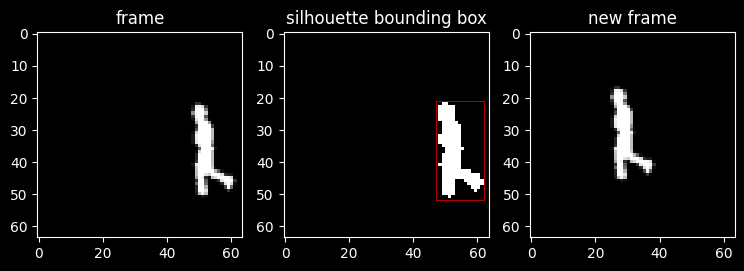

In [51]:
fig, axs = plt.subplots(1, 3, figsize=(3 * 3, 3))


axs[0].imshow(
    example_frame[0],
    cmap='grey',
    vmin=0, vmax=1, 
)
axs[0].set_title('frame')


axs[1].imshow(
    strickt_silhouette,
    cmap='grey',
    vmin=0, vmax=1, 
)
# plot a bounding box
delta = 1
silhouette_rect = patches.Rectangle(
    (x_ids[0] - delta, y_ids[0] - delta), 
    x_ids[-1] - x_ids[0] + 2 * delta, y_ids[-1] - y_ids[0] + 2 * delta, 
    linewidth=0.5, 
    edgecolor='r',
    facecolor='none'
)
axs[1].add_patch(silhouette_rect)
axs[1].set_title('silhouette bounding box')


axs[2].imshow(
    transforms_for_silhouette(silhouette_this),
    cmap='grey',
    vmin=0, vmax=1, 
)
axs[2].set_title('new frame')


plt.show()

#### Exclude cutted (incomplete) silhouettes

In [52]:
EXCLUDE_CUTTED = VARIABLES['exclude_cutted_silhouettes']
# Comment: Some frames are cutted because for some actions a person appears within 
#          a frame and goes to the opposite boundary! 

# Criterias to exclude a frame because of a part of a silhouette is out of frame:
# 1. one of boundaries of a silhouette bounding box coincides with a boundary of a frame;
# 2. if 1^st criteria satisfied and a width of a silhouette bounding box is less than some value
CUTTED_MIN_WIDTH = 15

#### Example of a cutted silhouette (if `EXCLUDE_CUTTED == True`)

This process performed within a dataset (see <span style="color:red">Data class</span> below).

In [53]:
# all actions
print(*ACTIONS)

bend jack jump pjump run side skip walk wave1 wave2


In [54]:
# all persons
print(*PERSONS)

daria denis eli ido ira lena lyova moshe shahar


In [55]:
example_act = 'walk'  # select example
example_person = 'moshe'
example_frame_number = 0

example_path = f'{WEIZMANN_DIR}/{example_act}_masks/{example_person}_{example_act}.npy'

In [56]:
try:
    example_frame = np.load(example_path)[example_frame_number]
except KeyError:
    print('There is no such file in a train set')

**<span style="color:red">Comment:</span>** We will center a silhouette along both axes! Here is a small problem due to the fact that persons are of different heights! Anyway, we will transform all silhouettes equally: selecting a silouethe rectangle (here is a problem with body parts entering or leaving a frame), pad it to a square + other transforms...

In [57]:
strickt_silhouette = torch.where(torch.tensor(example_frame)[0] > BRIGHTNESS_LIM, 1.0, 0.0)

# find a bounding box for a silhouette
# along y direction
y_ids = torch.where(strickt_silhouette.sum(dim=1) > 0)[0] # indices
# along x direction
x_ids = torch.where(strickt_silhouette.sum(dim=0) > 0)[0] # indices

In [58]:
silhouette_this = torch.tensor(example_frame[0, y_ids[0]:y_ids[-1] + 1, x_ids[0]:x_ids[-1] + 1])
silhouette_this.shape

torch.Size([32, 4])

In [59]:
rect_y = (y_ids[-1] - y_ids[0] + 1).item()
rect_x = (x_ids[-1] - x_ids[0] + 1).item()

assert (silhouette_this.shape[0] == rect_y) and (silhouette_this.shape[1] == rect_x)

In [60]:
# transform selected rectangle to square, centering a silhouette
square_size = CENTERED_MASK_SIZE

# paddings along OY
pad_top_silhouette = int((square_size - rect_y) / 2)
pad_bottom_silhouette = square_size - pad_top_silhouette - rect_y
# paddings along OX
pad_left_silhouette = int((square_size - rect_x) / 2)
pad_right_silhouette = square_size - pad_left_silhouette - rect_x  # params for transforms.Pad

transforms_for_silhouette = transforms.Compose(
  [
      transforms.Pad(
          padding=(
              pad_left_silhouette,  # left padding
              pad_top_silhouette,  # top padding
              pad_right_silhouette,  # right padding
              pad_bottom_silhouette  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
  ]  
)

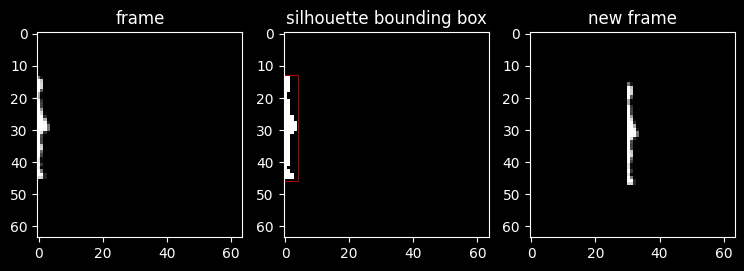

In [61]:
fig, axs = plt.subplots(1, 3, figsize=(3 * 3, 3))


axs[0].imshow(
    example_frame[0],
    cmap='grey',
    vmin=0, vmax=1, 
)
axs[0].set_title('frame')


axs[1].imshow(
    strickt_silhouette,
    cmap='grey',
    vmin=0, vmax=1, 
)
# plot a bounding box
delta = 1
silhouette_rect = patches.Rectangle(
    (x_ids[0] - delta, y_ids[0] - delta), 
    x_ids[-1] - x_ids[0] + 2 * delta, y_ids[-1] - y_ids[0] + 2 * delta, 
    linewidth=0.5, 
    edgecolor='r',
    facecolor='none'
)
axs[1].add_patch(silhouette_rect)
axs[1].set_title('silhouette bounding box')


axs[2].imshow(
    transforms_for_silhouette(silhouette_this),
    cmap='grey',
    vmin=0, vmax=1, 
)
axs[2].set_title('new frame')


plt.show()

In [62]:
print(f'Cutted silhouette width: {x_ids[-1] - x_ids[0]}')

Cutted silhouette width: 3


### 2.3.1. Dataset class

In [63]:
class WeizmannDsWfSeqs(Dataset):

    def __init__(
        self,
        ds_filepathes,
        transformations: transforms.Compose,  # at least ToWavefront() needed!
        sim_params: SimulationParameters,
        augmentation_horizontally_flip: bool = False,
        target: str = 'detector',
        detector_mask: torch.Tensor | None = None
    ):
        """
        Parameters
        ----------
        ds_filepathes : list
            A list of filepathes with masks sequences.
        transformations : transforms.Compose
            A sequence of transforms that will be applied to each frame.
        sim_params : SimulationParameters
            Simulation parameters for a further optical network.
        augmentation_horizontally_flip: bool
            If True an augmentation (horizontally flip) applying.
            Size of the dataset increases 2 times! 
        terget : str
            A type of target
                (1) 'label' - returns just a number of class
                (2) 'detector' - returns an expected detector picture + label
        detector_mask: torch.Tensor | None
            A detector mask to generate target images (if tardet == 'detector')
        """
        self.ds_filepathes = ds_filepathes
        self.augmentation_horizontally_flip = augmentation_horizontally_flip

        # load all masks at once
        self.all_np_masks, self.files_lengths, self.files_silhouettes_coord = self.load_masks()
        self.ds_constructor, self.seqs_counter = self.get_ds_constructor()
        
        self.sim_params = sim_params  # to check if all transforms results in right shape

        self.transformations = transformations
        self.check_transformations()  # print warnings if necessary
        
        self.target = target
        self.detector_mask = detector_mask

    def check_silhouette_not_cutted(self, filepath, frame_ind):
        """
        Returns a boolean value telling if a silhouette is cutted (incomplete).
            True  - silhouette is OK
            False - silhouette is cutted, it is better to exclude it
        """
        if self.files_silhouettes_coord[filepath][frame_ind] is None:
            return False  # no silhouette!

        upper_left_y, upper_left_x, lower_right_y, lower_right_x = self.files_silhouettes_coord[filepath][frame_ind]

        if (upper_left_x == 0) or (lower_right_x == INIT_MASK_SIZE - 1):
            # 1. one of boundaries of a silhouette bounding box coincides with a boundary of a frame;
            width = lower_right_y - upper_left_y

            if width < CUTTED_MIN_WIDTH:
                # 2. if 1^st criteria satisfied and a width of a silhouette bounding box is less than some value
                return False
        # all is OK
        return True

    def get_ds_constructor(self):
        """
        Returns
            1. list of pairs (filename index, [timesteps for sequence]);
            2. dictianory {action: number of sequences in dataset of the certain kind}.

        Comment: Here we also exclude all subsequences with cutted silhouette (if EXCLUDE_CUTTED is True)
        """
        ds_constructor = []  # pairs: (train file index, [NETWORK_SEQ timesteps in the file])
        seqs_counter = {}
        
        for ind_file, filepath in enumerate(self.ds_filepathes):
            action_name = filepath.split('/')[-2].split('_')[0]  # depends on a data directory!
            if action_name not in seqs_counter.keys():
                seqs_counter[action_name] = 0
            
            timesteps_this = self.files_lengths[filepath]
            opposite_boundary_reached = False
            
            for ind_timestep in range(timesteps_this):
                if EXCLUDE_CUTTED: # check if not cutted
                    if self.check_silhouette_not_cutted(filepath, ind_timestep):
                        pass
                    else:  # first subseq silhouette is cutted - skip
                        continue

                seq_this = [ind_timestep]
                
                ind_this = ind_timestep
                for step in range(1, NETWORK_SEQ):  # NETWORK_SEQ frames for each sub-sequence 
                    ind_this += SKIP + 1  # with a frame interval of SKIP
                    if ind_this <= timesteps_this - 1:
                        if EXCLUDE_CUTTED: # check if not cutted (reached another boundary of a frame!)
                            if self.check_silhouette_not_cutted(filepath, ind_this):
                                pass
                            else:  # first subseq silhouette is cutted - skip
                                opposite_boundary_reached = True
                                break
                        seq_this.append(ind_this)

                if EXCLUDE_CUTTED and opposite_boundary_reached:
                    break  # go to the next file! opposite boundary reached!
            
                if len(seq_this) == NETWORK_SEQ:
                    ds_constructor.append((ind_file, seq_this))
                    if not self.augmentation_horizontally_flip:
                        seqs_counter[action_name] += 1
                    else:  # count each sequence twice (normal + flipped)
                        seqs_counter[action_name] += 2

        return ds_constructor, seqs_counter

    def load_masks(self):
        """
        Load all masks by filepathes and returns two dictionaries
            1. {filepath: video masks}
            2. {filepath: number of frames in a video}
            3. {filepath: list (len = number of timesteps in a file) of tuples;
                          each tuple: (ul_corner_y, ul_corner_x, lr_corner_y, lr_corner_x)}
        """
        all_np_masks = {}
        files_lengths = {}
        files_silhouette_bounds = {}

        for filepath in self.ds_filepathes:
            all_np_masks[filepath] = np.load(filepath)  # [:, 0, :, :]
            files_lengths[filepath] = all_np_masks[filepath].shape[0]

            if CENTERING:  # if we need to center each silhouette
                # for each timestep of a video finding a bounding box for a silhouette
                for ind_frame in range(files_lengths[filepath]):
                    frame_this = all_np_masks[filepath][ind_frame, 0, :, :]

                    strickt_silhouette = torch.where(
                        torch.tensor(frame_this) > BRIGHTNESS_LIM, 1.0, 0.0
                    )

                    if strickt_silhouette.sum() > 0:
                        # indices, where a silhouette is:
                        y_ids = torch.where(strickt_silhouette.sum(dim=1) > 0)[0]  # along y direction
                        x_ids = torch.where(strickt_silhouette.sum(dim=0) > 0)[0]  # along x direction

                        coordinates_this = (
                            y_ids[0].item(), x_ids[0].item(),
                            y_ids[-1].item(), x_ids[-1].item()
                        )
                    else:  # no silhouette (is it possible?)
                        coordinates_this = None

                    if filepath in files_silhouette_bounds.keys():
                        files_silhouette_bounds[filepath].append(coordinates_this)
                    else:
                        files_silhouette_bounds[filepath] = [coordinates_this]

        return all_np_masks, files_lengths, files_silhouette_bounds
        
    def check_transformations(self):
        """
        Checks if transformations transforms an image to a right-shaped Wavefront.
        """
        random_image = torch.rand(size=(1, 5, 5))  # random image
        wavefront = self.transformations(random_image)

        # check type
        if not isinstance(wavefront, Wavefront):
            warnings.warn(
                message='An output object is not of the Wavefront type!'
            )

        # compare nodes number of the resulted Wavefront (last two dimensions) with simulation parameters
        sim_nodes_shape = self.sim_params.axes_size(axs=('H', 'W'))

        if not wavefront.size()[-2:] == sim_nodes_shape:
            warnings.warn(
                message='A shape of a resulted Wavefront does not match with SimulationParameters!'
            )

    def __len__(self):
        if self.augmentation_horizontally_flip:
            return 2 * len(self.ds_constructor)
        else:
            return len(self.ds_constructor)

    def centered_silhouette(self, filepath, frame_ind):
        """
        Returns centered silhouettes for frame number `frame_ind` of `filepath` video.
        """
        # silhouette box coordinates
        upper_left_y, upper_left_x, lower_right_y, lower_right_x = self.files_silhouettes_coord[filepath][frame_ind]
        
        silhouette_this = torch.tensor(
            self.all_np_masks[filepath][frame_ind, 0, upper_left_y:lower_right_y + 1, upper_left_x:lower_right_x + 1]
        )  # size equal to bounding box size!
        rect_y, rect_x = silhouette_this.shape
        
        # transform selected rectangle to square, centering a silhouette
        square_size = CENTERED_MASK_SIZE
        # paddings along OY
        pad_top_silhouette = int((square_size - rect_y) / 2)
        pad_bottom_silhouette = square_size - pad_top_silhouette - rect_y
        # paddings along OX
        pad_left_silhouette = int((square_size - rect_x) / 2)
        pad_right_silhouette = square_size - pad_left_silhouette - rect_x  # params for transforms.Pad
        
        transform_for_silhouette = transforms.Pad(
            padding=(
                pad_left_silhouette,  # left padding
                pad_top_silhouette,  # top padding
                pad_right_silhouette,  # right padding
                pad_bottom_silhouette  # bottom padding
            ),
            fill=0,
        )  # 0's padding to match sizes!

        return transform_for_silhouette(silhouette_this).unsqueeze(0)

    def __getitem__(self, ind: int) -> tuple:
        """
        Returns wavefront, target image in detector (for self.target == 'detector') and label.
        Comment: Here we are also centering silhouettes if CENTERING == True.
        
        Parameters
        ----------
        ind : int
            Index of element to return.

        Returns
        -------
        tuple
            An element of dataset: tuple(Wavefront, class)
            A size of a wavefront must be in a correspondence with simulation parameters!
        """
        if self.augmentation_horizontally_flip:
            ind_this = ind // 2  # if ind is odd - normal video, if ind is even - horizontally flipped
        else:
            ind_this = ind
    
        ind_filepath, frames_ids = self.ds_constructor[ind_this]
        
        filepath = self.ds_filepathes[ind_filepath]
        action_name = filepath.split('/')[-2].split('_')[0]  # depends on a data directory!
        label = ACTION_TO_ID[action_name]  # label for the sequence

        if (not self.augmentation_horizontally_flip) or (self.augmentation_horizontally_flip and ind_this % 2 == 0):
            sequence_raw = [
                torch.tensor(
                    self.all_np_masks[filepath][frame_ind, :, :, :]  # preserving dim=1 - channels
                )
                if not CENTERING else
                self.centered_silhouette(filepath, frame_ind)
                for frame_ind in frames_ids
            ]
        else:  # horizontally flipped frames
            sequence_raw = [ 
                torch.flip(  # horizontally flip
                    torch.tensor(
                        self.all_np_masks[filepath][frame_ind, :, :, :]  # preserving dim=1 - channels
                    ), dims=[-1]
                ) 
                if not CENTERING else
                torch.flip(self.centered_silhouette(filepath, frame_ind), dims=[-1])
                for frame_ind in frames_ids
            ]
        
        # apply transformations
        sequence_wavefronts = torch.stack(
            [self.transformations(frame) for frame in sequence_raw], dim=0
        )

        if self.target == 'label':
            return sequence_wavefronts, label

        if self.target == 'detector':
            if self.detector_mask is None:  # no detector mask provided
                warnings.warn(
                    message='No Detector mask provided to generate targets!'
                )
            else:
                detector_image = torch.where(label == self.detector_mask, 1.0, 0.0)
                return sequence_wavefronts, detector_image, label

In [64]:
# dataset of all files (WILL NOT USE IT FURTHER!)
all_seqs_ds = WeizmannDsWfSeqs(
    all_files,
    transforms.Compose(
        [
            transforms.Resize(size=SIM_PARAMS.axes_size(axs=('H', 'W'))),
            ToWavefront(modulation_type='amp')
        ]
    ),
    SIM_PARAMS,
    augmentation_horizontally_flip=False,  # no horizontal flip!
    target='label',
)  # item: (image wavefront, label)

print(
    f"All files subseq (exclude cutted = {VARIABLES['exclude_cutted_silhouettes']}, centered = {VARIABLES['center_silhouettes']}): " +
    f'{len(all_seqs_ds)}'
)

All files subseq (exclude cutted = True, centered = True): 4980


#### Silhouettes height and width statistics

In [65]:
silhouettes_heights = []
silhouettes_widths = []

for filepath in tqdm(all_files):
    file_num_frames = len(all_seqs_ds.files_silhouettes_coord[filepath])
    for ind_frame in range(file_num_frames):
        if all_seqs_ds.files_silhouettes_coord[filepath][ind_frame] is None:  # no silhouette!
            silhouettes_heights.append(0)
            silhouettes_widths.append(0)
            continue
            
        y1, x1, y2, x2 = all_seqs_ds.files_silhouettes_coord[filepath][ind_frame]

        silhouettes_heights.append(y2 - y1)
        silhouettes_widths.append(x2 - x1)

100%|█████████████████████████████████████████████████████| 90/90 [00:00<00:00, 42476.35it/s]


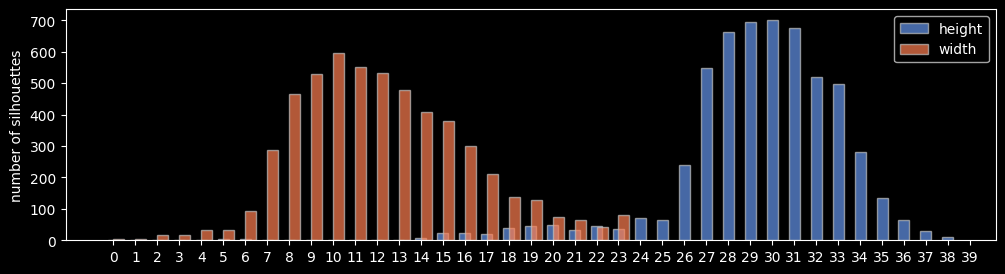

In [66]:
fig, ax0 = plt.subplots(1, 1, figsize=(12, 3))
bars_width = 0.5
bars_shift = 0.25

ax0.hist(
    silhouettes_heights, bins=list(range(40)),
    align='left', rwidth=bars_width, label='height',
    facecolor='cornflowerblue', edgecolor='silver', alpha=0.7
)
ax0.hist(
    np.array(silhouettes_widths) + bars_shift, bins=np.arange(25) + bars_shift,
    align='left', rwidth=bars_width, label='width',
    facecolor='coral', edgecolor='silver', alpha=0.7
)

ax0.set_xticks(range(40))
# ax0.set_xticklabels([ID_TO_ACTION[ind] for ind in range(NUM_ACTIONS)])

ax0.set_ylabel('number of silhouettes')
# ax0.set_ylim([0, 1000])

ax0.legend()
plt.show()

In [67]:
del all_seqs_ds

### 2.3.2. Transformations for each frame

In [68]:
MODULATION_TYPE = VARIABLES['modulation']

> We further included zero padding at the network periphery to guarantee the boundary condition of free-space diffraction during the numerical modelling using the angular spectrum method.

> Each video sequence has $\sim 30–100$ frames captured at a frame rate of $50$ f.p.s. with a resolution of $180 \times 144$, which was cropped to $144 \times 144$ and up-sampled four times with zero padding to $700 \times 700$ to match the input size of the D-RNN.

#### Dataset transforms

In [69]:
if APERTURES:
    resize_y = int(DETECTOR_SIZE[0] / 1)
    resize_x = int(DETECTOR_SIZE[1] / 1)
else:
    resize_y = int(LAYER_SIZE[0] / 3)
    resize_x = int(LAYER_SIZE[1] / 3)  # shape for transforms.Resize

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [70]:
# compose all transforms!
transforms_for_ds = transforms.Compose(
  [
      transforms.Resize(
          size=(resize_y, resize_x),
          # interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- select modulation type!!!
  ]  
)

### 2.3.2. Detector mask to generate targets for sub-sequences
> The number of output regions was set to be the same as the number of categories, that is, ten regions for the MNIST, Fashion-MNIST and Weizmann databases, and six regions for the KTH database, each with a width of $0.46$ mm.

In [71]:
import src.detector_segmentation as detector_segmentation

In [72]:
detector_segment_size = VARIABLES['detector_segment_size']

In [73]:
# size of each segment in neurons
x_segment_nodes = int(detector_segment_size / neuron_size)
y_segment_nodes = int(detector_segment_size / neuron_size)
# each segment of size = (y_segment_nodes, x_segment_nodes)

In [74]:
y_boundary_nodes = y_segment_nodes * 9
x_boundary_nodes = x_segment_nodes * 9

In [75]:
DETECTOR_MASK = detector_segmentation.squares_mnist(
    y_boundary_nodes, x_boundary_nodes,  # size of a detector or an aperture (in the middle of detector)
    SIM_PARAMS
)  # here we use the same segmentation as for MNIST: the number of classes is the same

**<span style="color:red">Comment:</span>** This mask will be used to generate a target image for each number! 

**<span style="color:red">Target image on detector:</span>** zeros are everywhere except the necessary zone responsible for the label! 

#### To visualize detector zones (for further use)

In [76]:
ZONES_HIGHLIGHT_COLOR = 'r'
ZONES_LW = 0.5
selected_detector_mask = DETECTOR_MASK.clone().detach()

In [77]:
def get_zones_patches(detector_mask):
    """
    Returns a list of patches to draw zones in final visualisation
    """
    zones_patches = []

    delta = 1 #0.5
    
    for ind_class in range(NUM_ACTIONS):
        idx_y, idx_x = (detector_mask == ind_class).nonzero(as_tuple=True)
        
        zone_rect = patches.Rectangle(
            (idx_x[0] - delta, idx_y[0] - delta), 
            idx_x[-1] - idx_x[0] + 2 * delta, idx_y[-1] - idx_y[0] + 2 * delta, 
            linewidth=ZONES_LW, 
            edgecolor=ZONES_HIGHLIGHT_COLOR,
            facecolor='none'
        )
        
        zones_patches.append(zone_rect)

    return zones_patches

#### Visualize mask

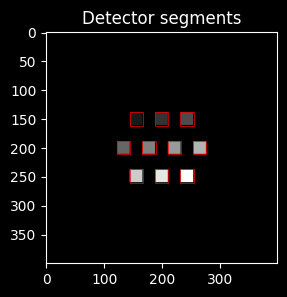

In [78]:
fig, ax0 = plt.subplots(1, 1, figsize=(3, 3))

ax0.set_title(f'Detector segments')
ax0.imshow(selected_detector_mask, cmap='grey')

for zone in get_zones_patches(selected_detector_mask):
    # add zone's patches to the axis
    # zone_copy = copy(zone)
    ax0.add_patch(zone)

plt.show()

### 2.3.3. Train and Test datasets of wavefronts sequences

In [79]:
# if True uses a horisotal flip to make dataset twice as large
AUGMENTATION_FLIP = VARIABLES['augmentation_flip']

In [80]:
AUGMENTATION_FLIP

True

In [81]:
train_seqs_ds = WeizmannDsWfSeqs(
    all_train_files,
    transforms_for_ds,
    SIM_PARAMS,
    augmentation_horizontally_flip=AUGMENTATION_FLIP,
    target='detector',
    detector_mask=DETECTOR_MASK,
)  # item: (image wavefront, target detector tensor, label)

test_seqs_ds = WeizmannDsWfSeqs(
    all_test_files,
    transforms_for_ds,
    SIM_PARAMS,
    augmentation_horizontally_flip=AUGMENTATION_FLIP,
    target='detector',
    detector_mask=DETECTOR_MASK,
)  # item: (image wavefront, target detector tensor, label)

In [82]:
print(f'Train dataset of sequences: {len(train_seqs_ds)}')
print(f'Test  dataset of sequences: {len(test_seqs_ds)}')

Train dataset of sequences: 6896
Test  dataset of sequences: 3064


#### Classes disbalance

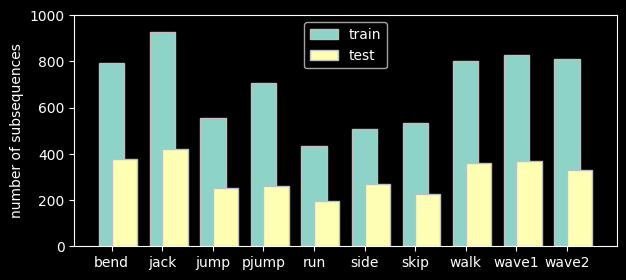

In [83]:
train_list = [ACTION_TO_ID[key] for key, val in train_seqs_ds.seqs_counter.items() for _ in range(val)]
test_list = [ACTION_TO_ID[key] for key, val in test_seqs_ds.seqs_counter.items() for _ in range(val)]


fig, ax0 = plt.subplots(1, 1, figsize=(7, 3))
bars_width = 0.5
bars_shift = 0.25

ax0.hist(
    train_list, bins=list(range(NUM_ACTIONS + 1)),
    align='left', rwidth=bars_width, label='train',
    edgecolor='silver'
)
ax0.hist(
    np.array(test_list) + bars_shift, bins=np.arange(NUM_ACTIONS + 1) + bars_shift,
    align='left', rwidth=bars_width, label='test',
    edgecolor='silver'
)

ax0.set_xticks(range(NUM_ACTIONS))
ax0.set_xticklabels([ID_TO_ACTION[ind] for ind in range(NUM_ACTIONS)])

ax0.set_ylabel('number of subsequences')
ax0.set_ylim([0, 1000])

ax0.legend()
plt.show()

#### Weights of classes (based on train dataset)

In [84]:
WEIGHTED_CLASSES = VARIABLES['weighted_detector_zones']  # if we need to use weights for classes to balance

In [85]:
if WEIGHTED_CLASSES:
    max_class_size = max(train_seqs_ds.seqs_counter.values())
    
    weights_dict = {
        key: max_class_size / value 
        for key, value in train_seqs_ds.seqs_counter.items()
    }

    WEIGHTS_DETECTOR = [weights_dict[ID_TO_ACTION[i]] for i in range(NUM_ACTIONS)]
    WEIGHTS_DETECTOR = torch.tensor(WEIGHTS_DETECTOR).unsqueeze(0)

In [86]:
if WEIGHTED_CLASSES:
    WEIGHTS_DICT = weights_dict

**<span style="color:red">TODO:</span>** How to use weights for MSE loss? 


In [87]:
if WEIGHTED_CLASSES:
    for key, val in weights_dict.items():
        print(f'{key}\t:\t{val}')

    # detector weights mask
    DETECTOR_WEIGHTS_MASK = torch.zeros(
        size=SIM_PARAMS.axes_size(axs=('W', 'H'))
    )
    for act in ACTIONS:
        id_act = ACTION_TO_ID[act]
        DETECTOR_WEIGHTS_MASK += torch.where(DETECTOR_MASK == id_act, weights_dict[act], 0.0)
    DETECTOR_WEIGHTS_MASK += torch.where(DETECTOR_MASK == -1, 1.0, 0.0)

bend	:	1.1717171717171717
jack	:	1.0
jump	:	1.669064748201439
pjump	:	1.3144475920679888
run	:	2.1481481481481484
side	:	1.8339920948616601
skip	:	1.7378277153558053
walk	:	1.1571072319201996
wave1	:	1.1180722891566266
wave2	:	1.145679012345679


### 2.3.4. Examples of sequences from Train dataset

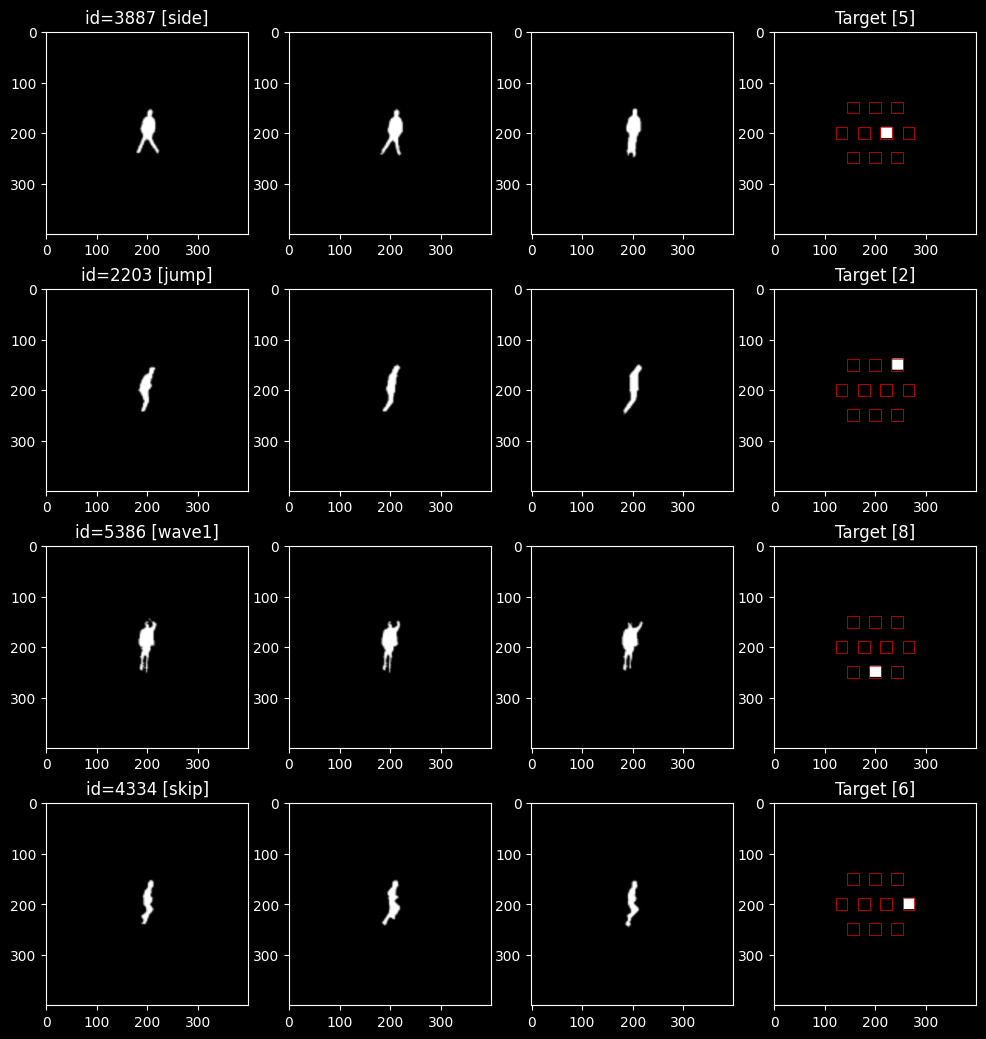

In [88]:
# plot several EXAMPLES from TRAIN dataset
n_examples= 4  # number of examples to plot
# choosing indecies of images (from train) to plot
random.seed(12)
train_examples_ids = random.sample(range(len(train_seqs_ds)), n_examples)

n_cols = NETWORK_SEQ + 1  # number of columns to plot masks (last column for targets)
to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'

fig, axs = plt.subplots(n_examples, n_cols, figsize=(n_cols * 3, n_examples * 3.2))

for ind_ex, ind_train in enumerate(train_examples_ids):
    sequence, target, label = train_seqs_ds[ind_train]
    # print(sequence.shape)
    
    for frame_ind in range(NETWORK_SEQ):
        frame_this_wf = sequence[frame_ind]
        # print(f'Example #{ind_ex}, frame #{frame_ind + 1}: {frame_this_wf.shape}')
        
        assert isinstance(frame_this_wf, Wavefront)
        
        if frame_ind == 0:
            axs[ind_ex][frame_ind].set_title(f'id={ind_train} [{ID_TO_ACTION[label]}]')

        if to_plot == 'amp':
            axs[ind_ex][frame_ind].imshow(
                frame_this_wf.intensity, cmap=cmap,
                vmin=0, vmax=1, 
            )
        else: 
            axs[ind_ex][frame_ind].imshow(frame_this_wf.phase, cmap=cmap)

    axs[ind_ex][frame_ind + 1].set_title(f'Target [{label}]')
    axs[ind_ex][frame_ind + 1].imshow(target, cmap=cmap)
    
    for zone in get_zones_patches(DETECTOR_MASK):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        axs[ind_ex][frame_ind + 1].add_patch(zone)
    
plt.show()

# 3. Recurrent Optical Network

<div>
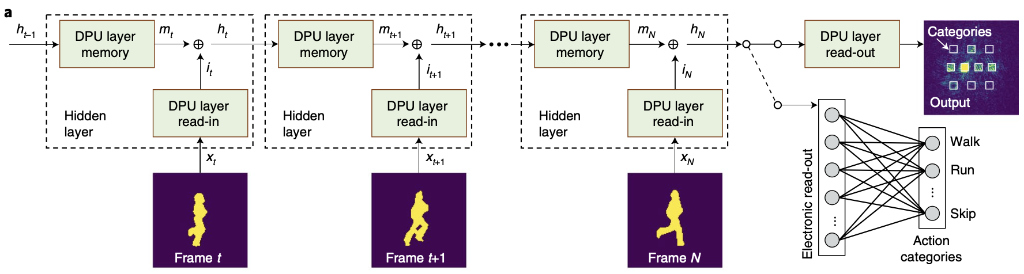
</div>

Fig. 4(a) from [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4).

> For the D-RNN hidden layer at the time step of $t$, the hidden state ht is a function of the hidden state ht−1 at the time step of $t−1$ and of the input sequence $x_t$ at the time step of $t$. We
adopt an affine combination to fuse the states from these two sources, that is, $h_t=\lambda f_1(h_{t-1})+(1-\lambda)f_2(x_t)$, where $m_t=f_1(h_{t-1})$ denotes the memory state mapping from $h_{t-1}$; $i_t=f_2(x_t)$ denotes the input state mapping from $x_t$; and $\lambda\in(0,1)$ is the fusing coefficient that controls the strength of the memory state with respect to the input state.

## 3.1. Reproducing of a network architecture

### 3.1.1. Some constatns

In [89]:
FUSING_COEFF = VARIABLES['fusing_coefficient']  # the best value according to the article [1] results

In [90]:
MAX_PHASE = VARIABLES['max_phase']  # maximal phase for diffractive layers
INIT_PHASE = VARIABLES['init_phase']  # initial phase for Diffractive layers

> The layer distance for optical diffraction was optimized and set to $20$ cm

<span style="color:red">**Comment:**</span> Another value used!

In [91]:
# DISTANCE = 20 * 1e-2  # [m]
FS_METHOD = VARIABLES['free_space_method']
DISTANCE = VARIABLES['free_space_distance']  # [m]

### 3.1.2. Functions to get new elements

In [92]:
def get_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    Returns FreeSpace layer with a bounded distance parameter.
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )


def get_const_phase_layer(
    sim_params: SimulationParameters,
    value, max_phase=2 * torch.pi
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value
    
    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
    )  # ATTENTION TO DOCUMENTATION!

In [93]:
if APERTURES:
    # equal masks for all apertures (select a part in the middle)
    APERTURE_MASK = torch.ones(size=DETECTOR_SIZE)

    y_nodes, x_nodes = SIM_PARAMS.axes_size(axs=('H', 'W'))
    y_mask, x_mask = APERTURE_MASK.size()
    pad_top = int((y_nodes - y_mask) / 2)
    pad_bottom = y_nodes - pad_top - y_mask
    pad_left = int((x_nodes - x_mask) / 2)
    pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad
    
    # padding transform to match aperture size with simulation parameters     
    APERTURE_MASK = functional.pad(
        input=APERTURE_MASK,
        pad=(pad_left, pad_right, pad_top, pad_bottom),
        mode='constant',
        value=0
    )

In [94]:
def get_nonlinear_layer(
    sim_params: SimulationParameters,
):
    """
    Returns NonlinearElement ~ x^2 (for amplitudes == for intensities).
        Comment: attention to the NonlinearElement documentation!
    """
    
    return elements.NonlinearElement(
        simulation_parameters=sim_params,
        response_function=lambda x: x ** 2,
    )

### 3.1.3. Model class

<span style="color:red">**Comment:**</span> Check FreeSpaces here!

<span style="color:red">**Comment:**</span> Apertures added (if `APERTURES == True`) before each `DiffractiveLayer` (in `read-in`, `memory` and `read-out`)!

<span style="color:red">**Comment:**</span> Flags for using nonlinear layers in RNN layers are defined in `VARIABLES`!

In [95]:
READ_IN_NONLIN, MEMORY_NONLIN, READ_OUT_NONLIN = VARIABLES['use_nonlinear_layers']

In [96]:
VARIABLES['read_in_freespace']

False

### Optical RNN parts (`read-in`, `memory`, `read-out`)

In [97]:
def get_readin_layer(sim_params, fs_method):
    """
    Returns nn.Sequential for a Read-in layer of an optical RNN.
    """
    elements_list = []

    # FREE SPACE
    if VARIABLES['read_in_freespace']:
        elements_list.append(
            get_free_space(
                sim_params,
                DISTANCE,  # in [m]!
                freespace_method=fs_method,
            )
        )
    
    if APERTURES:  # APERTURE if needed
        elements_list.append(
            elements.Aperture(
                sim_params,
                mask=APERTURE_MASK,
            )
        )

    # PHASE LAYER (Diffractive layer)
    elements_list.append(
        get_const_phase_layer(
            sim_params,
            INIT_PHASE, max_phase=MAX_PHASE
        )
    )
    
    if READ_IN_NONLIN:  # NONLINEAR LAYER if needed
        elements_list.append(
            get_nonlinear_layer(sim_params),  # <- nonlinear layer after DiffractiveLayer!
        )

    # FREE SPACE
    elements_list.append(
        get_free_space(
            sim_params,
            DISTANCE,  # in [m]!
            freespace_method=fs_method,
        )
    )
    
    return nn.Sequential(*elements_list)


def get_memory_layer(sim_params, fs_method):
    """
    Returns nn.Sequential for a Memory layer of an optical RNN.
    """
    elements_list = []
    
    if APERTURES:  # APERTURE if needed
        elements_list.append(
            elements.Aperture(
                sim_params,
                mask=APERTURE_MASK,
            )
        )

    # PHASE LAYER (Diffractive layer)
    elements_list.append(
        get_const_phase_layer(
            sim_params,
            INIT_PHASE, max_phase=MAX_PHASE
        )
    )
        
    if MEMORY_NONLIN:  # NONLINEAR LAYER if needed
        elements_list.append(
            get_nonlinear_layer(sim_params),  # <- nonlinear layer after DiffractiveLayer!
        )

    # FREE SPACE
    elements_list.append(
        get_free_space(
            sim_params,
            DISTANCE,  # in [m]!
            freespace_method=fs_method,
        )
    )

    return nn.Sequential(*elements_list)


def get_readout_layer(sim_params, fs_method):
    """
    Returns nn.Sequential for a Read-out layer of an optical RNN.
    """
    elements_list = []

    if APERTURES:  # APERTURE if needed
        elements_list.append(
            elements.Aperture(
                sim_params,
                mask=APERTURE_MASK,
            )
        )

    # PHASE LAYER (Diffractive layer)
    elements_list.append(
        get_const_phase_layer(
            sim_params,
            INIT_PHASE, max_phase=MAX_PHASE
        )
    )
        
    if READ_OUT_NONLIN:  # NONLINEAR LAYER if needed
        elements_list.append(
            get_nonlinear_layer(sim_params),  # <- nonlinear layer after DiffractiveLayer!
        )

    # FREE SPACE
    elements_list.append(
        get_free_space(
            sim_params,
            DISTANCE,  # in [m]!
            freespace_method=fs_method,
        )
    )

    return nn.Sequential(*elements_list)

In [98]:
def get_detector_layer(sim_params):
    if not APERTURES:
        return Detector(
            sim_params,
            func='intensity'  # detector that returns intensity
        )
    else:  # add aperture before detector if needed
        return nn.Sequential(
            elements.Aperture(
                sim_params,
                mask=APERTURE_MASK,
            ),  # <- aperture
            # get_nonlinear_layer(self.sim_params),  # <- nonlinear layer after DiffractiveLayer!
            Detector(
                sim_params,
                func='intensity'  # detector that returns intensity
            )
        )

### Optical RNN class

In [99]:
class DiffractiveRNN(nn.Module):
    """
    A recurrent diffractive netvork proposed in [1].
    """

    def __init__(
        self,
        sequence_size: int,
        fusing_coeff: float,
        sim_params: SimulationParameters,
        fs_method: str = 'AS',
        device: str | torch.device = torch.get_default_device(),
    ):
        """
        sequence_size: int
            A selected size (number of frames) of sub-sequences for action prediction.
        fusing_coeff: float
            A coefficient in a function for a hidden state (lambda in methods [1]).
        sim_params: SimulationParameters
            Simulation parameters for the task.
        fs_method: str
            A method for a free space.
        """
        super().__init__()

        self.sequence_len = sequence_size
        self.fusing_coeff = fusing_coeff
        self.sim_params = sim_params

        self.h, self.w = self.sim_params.axes_size(
            axs=('H', 'W')
        )  # height and width for a wavefronts
        
        self.__device = device
        self.fs_method = fs_method
        
        self.free_space_optimal = get_free_space(
            self.sim_params,
            DISTANCE,  # in [m]!
            freespace_method=self.fs_method,
        ).to(self.__device)  # untrainable free space between timesteps

        # ----------------------------------------------- READ-IN LAYER
        self.read_in_layer = get_readin_layer(
            self.sim_params, self.fs_method,
        ).to(self.__device)
        # ------------------------------------------------ MEMORY LAYER
        self.memory_layer = get_memory_layer(
            self.sim_params, self.fs_method,
        ).to(self.__device)
        # ---------------------------------------------- READ-OUT LAYER
        self.read_out_layer = get_readout_layer(
            self.sim_params, self.fs_method,
        ).to(self.__device).to(self.__device)
        # -------------------------------------------------------------
        # -------------------------------------------- DETECTOR (LAYER)
        self.detector = get_detector_layer(self.sim_params).to(self.__device)
        # -------------------------------------------------------------

    def forward(self, subsequence_wf):
        """
        Parameters
        ----------
        subsequence_wf: Wavefront('time', 'H', 'W')
            List of wavefronts for a video sub-sequence.
        """
        if len(subsequence_wf.shape) > 3:  # if a batch is an input
            batch_flag = True
            bs = subsequence_wf.shape[0]
            h_prev = Wavefront(
                torch.zeros(
                    size=(bs, self.h, self.w)
                )
            ).to(self.__device) # h_{t - 1} - reset hidden for the first input
        else:
            batch_flag = False
            h_prev = Wavefront(
                torch.zeros(
                    size=(self.h, self.w)
                )
            ).to(self.__device) # h_{t - 1} - reset hidden for the first input

        for frame_ind in range(self.sequence_len):
            if batch_flag:
                x_t = subsequence_wf[:, frame_ind, :, :]
            else:  # not a batch
                x_t = subsequence_wf[frame_ind, :, :]
                
            i_t = self.read_in_layer(x_t)  # f_2(x_t)

            m_t = self.memory_layer(h_prev)  # f_1(h_{t - 1})
            
            h_prev = self.fusing_coeff * m_t + (1 - self.fusing_coeff) * i_t
            h_prev = self.free_space_optimal(h_prev)

        out = self.read_out_layer(h_prev)
        
        return self.detector(out)

### Empty model

In [100]:
def get_rnn():
    return DiffractiveRNN(
        sequence_size=NETWORK_SEQ,
        fusing_coeff=FUSING_COEFF,
        sim_params=SIM_PARAMS,
        fs_method=FS_METHOD,
    )

### 3.1.4 Detector processor (to calculate accuracies only)

**<span style="color:red">Comment:</span>** `DetectorProcessor` in our library is used to process an information on detector. For example, for the current task `DetectorProcessor` must return only 10 values (1 value per 1 class).

In [101]:
CALCULATE_ACCURACIES = VARIABLES['calculate_accuracies']  # if False, accuracies will not be calculated!

if VARIABLES['loss'] == 'CE':
    CALCULATE_ACCURACIES = True  # always True for CrossEntropyLoss!

In [102]:
# create a DetectorProcessorOzcanClf object
if CALCULATE_ACCURACIES:
    if WEIGHTED_CLASSES:
        detector_processor = DetectorProcessorClf(
            simulation_parameters=SIM_PARAMS,
            num_classes=NUM_ACTIONS,
            segmented_detector=DETECTOR_MASK,
            segments_weights=WEIGHTS_DETECTOR,  # <- weights for zones integral!
        )
    else:
        detector_processor = DetectorProcessorClf(
            simulation_parameters=SIM_PARAMS,
            num_classes=NUM_ACTIONS,
            segmented_detector=DETECTOR_MASK,
        )
else:
    detector_processor = None

# 4. Training of the network

In [103]:
DEVICE = VARIABLES['DEVICE']  # 'mps' is not support a CrossEntropyLoss

In [104]:
if DEVICE == 'cuda':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

'cpu'

## 4.1. Prepare some stuff for training

### 4.1.1. `DataLoader`'s

Citations from methods of [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> For all three architectures, the learning rate was set to $0.01$, with a training batch size of ... $20$ for the D-RNN.

<span style="color:red">**Comment:**</span> We will make it smaller due to the fact our computations are on `cpu`.

In [105]:
train_bs = VARIABLES['train_batch_size']  # a batch size for training set
val_bs = VARIABLES['val_batch_size']

In [106]:
train_wf_loader = torch.utils.data.DataLoader(
    train_seqs_ds,
    batch_size=train_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

test_wf_loader = torch.utils.data.DataLoader(
    test_seqs_ds,
    batch_size=val_bs,
    shuffle=True,
    # num_workers=2,
    drop_last=False,
)

### 4.1.2. Optimizer and loss function

Citations from methods of [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> For all three architectures, the learning rate was set to $0.01$, with a training batch size of ... $20$ for the D-RNN.

> We adopt a stochastic gradient descent algorithm, that is, the adaptive moment estimation (Adam) optimizer ...

In [107]:
LR = VARIABLES['adam_lr']

In [108]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

**<span style="color:red">Comment:</span>** We are using `MSELoss` or `CrossEntropyLoss`! 

In [109]:
LOSS = VARIABLES['loss']

In [110]:
if LOSS == 'MSE':
    loss_func_clf = nn.MSELoss()  # by default: reduction='mean'
    loss_func_name = 'MSE'

if LOSS == 'CE':
    loss_func_clf = nn.CrossEntropyLoss()
    loss_func_name = 'CE loss'

### 4.1.3. Training and evaluation loops

In [111]:
def rnn_train(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR needed for accuracies only!
    loss_func, optimizer,
    device='cpu', show_process=False
):
    """
    Function to train `optical_net` (classification task)
    ...
    
    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        optimizer: torch.optim
            Optimizer...
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.
        
    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.train()  # activate 'train' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_accuracies = []  # to store accuracy for each batch
    
    correct_preds = 0
    size = 0
    ind_batch = 1
    
    for batch_wavefronts, batch_targets, batch_labels in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='train', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]
        
        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)
        batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()

        # forward of an optical network
        detector_outputs = optical_net(batch_wavefronts)

        if LOSS == 'CE':
            # process a detector image
            batch_probas = detector_processor_clf.batch_forward(detector_outputs)
            # calculate loss for a batch
            loss = loss_func(batch_probas, batch_labels)

        if LOSS == 'MSE':
            if WEIGHTED_CLASSES:
                batch_weights = torch.tensor(
                    [
                        WEIGHTS_DICT[ID_TO_ACTION[label_this.item()]] 
                        for label_this in batch_labels
                    ]
                ).to(device)
                # calculate loss for a batch
                loss = loss_func(
                    detector_outputs * batch_weights.view(-1, 1, 1), 
                    batch_targets.to(torch.float64) * batch_weights.view(-1, 1, 1)
                )
            else:
                # calculate loss for a batch
                loss = loss_func(detector_outputs, batch_targets.to(torch.float64))
        
        loss.backward()
        optimizer.step()

        # ACCURACY
        if CALCULATE_ACCURACIES:
            
            if LOSS == 'MSE':
                # process a detector image
                batch_probas = detector_processor_clf.batch_forward(detector_outputs)
            
            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()
            
            correct_preds += batch_correct_preds    
            size += batch_size
        
        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.
    
    return batches_losses, batches_accuracies, epoch_accuracy

In [112]:
def rnn_validate(
    optical_net, wavefronts_dataloader,
    detector_processor_clf,  # DETECTOR PROCESSOR NEEDED!
    loss_func,
    device='cpu', show_process=False
    ):
    """
    Function to validate `optical_net` (classification task)
    ...
    
    Parameters
    ----------
        optical_net : torch.nn.Module
            Neural Network composed of Elements.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        detector_processor_clf : DetectorProcessorClf
            A processor of a detector image for a classification task, that returns `probabilities` of classes.
        loss_func :
            Loss function for a multi-class classification task.
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.
        
    Returns
    -------
        batches_losses : list[float]
            Losses for each batch in an epoch.
        batches_accuracies : list[float]
            Accuracies for each batch in an epoch.
        epoch_accuracy : float
            Accuracy for an epoch.
    """
    optical_net.eval()  # activate 'eval' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_accuracies = []  # to store accuracy for each batch
    
    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_targets, batch_labels in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]
        
        batch_wavefronts = batch_wavefronts.to(device)
        batch_targets = batch_targets.to(device)
        batch_labels = batch_labels.to(device)
        
        with torch.no_grad():

            detector_outputs = optical_net(batch_wavefronts)

            if LOSS == 'CE':
                # process a detector image
                batch_probas = detector_processor_clf.batch_forward(detector_outputs)
                # calculate loss for a batch
                loss = loss_func(batch_probas, batch_labels)
            
            if LOSS == 'MSE':
                if WEIGHTED_CLASSES:
                    batch_weights = torch.tensor(
                        [
                            WEIGHTS_DICT[ID_TO_ACTION[label_this.item()]] 
                            for label_this in batch_labels
                        ]
                    ).to(device)
                    # calculate loss for a batch
                    loss = loss_func(
                        detector_outputs * batch_weights.view(-1, 1, 1), 
                        batch_targets * batch_weights.view(-1, 1, 1)
                    )
                else:
                    # calculate loss for a batch
                    loss = loss_func(detector_outputs, batch_targets)

        # ACCURACY
        if CALCULATE_ACCURACIES:

            if LOSS == 'MSE':
                # process a detector image
                batch_probas = detector_processor_clf.batch_forward(detector_outputs)
                
            batch_correct_preds = (
                batch_probas.argmax(1) == batch_labels
            ).type(torch.float).sum().item()
            
            correct_preds += batch_correct_preds    
            size += batch_size
        
        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        if CALCULATE_ACCURACIES:
            batches_accuracies.append(batch_correct_preds / batch_size)
        else:
            batches_accuracies.append(0.)

    if CALCULATE_ACCURACIES:
        epoch_accuracy = correct_preds / size
    else:
        epoch_accuracy = 0.
    
    return batches_losses, batches_accuracies, epoch_accuracy

## 4.2. Training of the optical network

### 4.2.1. Before training

#### Metrics for Test dataset

In [113]:
# Comment: not tested for `cuda`!
SIM_PARAMS = SIM_PARAMS.to(DEVICE)
rnn_no_train = get_rnn().to(DEVICE)

if detector_processor:
    detector_processor = detector_processor.to(DEVICE)

In [114]:
test_losses_0, _, test_accuracy_0 = rnn_validate(
    rnn_no_train,  # optical recurrent network composed in 3.
    test_wf_loader,  # dataloader of training set
    detector_processor,  # detector processor
    loss_func_clf,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results before training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_0):.6f}\n' +
    f'\tAccuracy : {(test_accuracy_0*100):>0.1f} %'
)

validation: 100%|██████████████████████████████████████████| 154/154 [02:20<00:00,  1.10it/s]

Results before training on TEST set:
	CE loss : 2.327323
	Accuracy : 7.2 %


**<span style="color:red">Comment:</span>** Due to classes disbalance the obtained value is less than $\sim10\%$! 

### 4.2.2. Training

In [115]:
n_epochs = VARIABLES['number_of_epochs']
print_each = 1  # print each n'th epoch info

In [116]:
# Recreate a system to restart training!
# Comment: not tested for `cuda`!
SIM_PARAMS = SIM_PARAMS.to(DEVICE)
dai_rnn = get_rnn().to(DEVICE)

if detector_processor:
    detector_processor = detector_processor.to(DEVICE)

# Linc optimizer to a recreated net!
optimizer_clf = get_adam_optimizer(dai_rnn)

In [117]:
scheduler = None  # sheduler for a lr tuning during training 

In [118]:
train_epochs_losses = []
val_epochs_losses = []  # to store losses of each epoch

train_epochs_acc = []
val_epochs_acc = []  # to store accuracies

torch.manual_seed(98)  # for reproducability?

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_losses, _, train_accuracy = rnn_train(
        dai_rnn,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        detector_processor,  # detector processor
        loss_func_clf,
        optimizer_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # train info
        print('Training results')
        print(f'\t{loss_func_name} : {mean_train_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tAccuracy : {(train_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_losses, _, val_accuracy = rnn_validate(
        dai_rnn,  # optical network composed in 3.
        test_wf_loader,  # dataloader of validation set
        detector_processor,  # detector processor
        loss_func_clf,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} : {mean_val_loss:.6f}')
        if CALCULATE_ACCURACIES:
            print(f'\tAccuracy : {(val_accuracy*100):>0.1f} %')
        print(f'\t------------   {time.time() - start_val_time:.2f} s')
            
    if scheduler:
        scheduler.step(mean_val_loss)

    # save losses
    train_epochs_losses.append(mean_train_loss)
    val_epochs_losses.append(mean_val_loss)
    # seve ac curacies
    train_epochs_acc.append(train_accuracy)
    val_epochs_acc.append(val_accuracy)

Epoch #1: 

train: 100%|███████████████████████████████████████████████| 690/690 [15:13<00:00,  1.32s/it]


Training results
	CE loss : 2.172647
	Accuracy : 40.3 %
	------------   913.35 s


validation: 100%|██████████████████████████████████████████| 154/154 [04:54<00:00,  1.91s/it]


Validation results
	CE loss : 2.148172
	Accuracy : 47.3 %
	------------   294.54 s
Epoch #2: 

train: 100%|███████████████████████████████████████████████| 690/690 [20:14<00:00,  1.76s/it]


Training results
	CE loss : 2.034153
	Accuracy : 64.1 %
	------------   1214.26 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:41<00:00,  1.05s/it]


Validation results
	CE loss : 2.104668
	Accuracy : 51.2 %
	------------   161.77 s
Epoch #3: 

train: 100%|███████████████████████████████████████████████| 690/690 [12:54<00:00,  1.12s/it]


Training results
	CE loss : 1.987504
	Accuracy : 68.6 %
	------------   774.82 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:37<00:00,  1.02s/it]


Validation results
	CE loss : 2.086942
	Accuracy : 51.6 %
	------------   157.64 s
Epoch #4: 

train: 100%|███████████████████████████████████████████████| 690/690 [12:51<00:00,  1.12s/it]


Training results
	CE loss : 1.963690
	Accuracy : 72.0 %
	------------   771.92 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:39<00:00,  1.03s/it]


Validation results
	CE loss : 2.077172
	Accuracy : 53.5 %
	------------   159.26 s
Epoch #5: 

train: 100%|███████████████████████████████████████████████| 690/690 [11:58<00:00,  1.04s/it]


Training results
	CE loss : 1.948444
	Accuracy : 74.0 %
	------------   718.39 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:25<00:00,  1.06it/s]


Validation results
	CE loss : 2.064419
	Accuracy : 55.8 %
	------------   145.52 s
Epoch #6: 

train: 100%|███████████████████████████████████████████████| 690/690 [11:37<00:00,  1.01s/it]


Training results
	CE loss : 1.938119
	Accuracy : 74.8 %
	------------   697.71 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:20<00:00,  1.10it/s]


Validation results
	CE loss : 2.062207
	Accuracy : 56.0 %
	------------   140.33 s
Epoch #7: 

train: 100%|███████████████████████████████████████████████| 690/690 [11:36<00:00,  1.01s/it]


Training results
	CE loss : 1.930097
	Accuracy : 75.6 %
	------------   696.22 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:21<00:00,  1.09it/s]


Validation results
	CE loss : 2.057425
	Accuracy : 58.7 %
	------------   141.87 s
Epoch #8: 

train: 100%|███████████████████████████████████████████████| 690/690 [11:38<00:00,  1.01s/it]


Training results
	CE loss : 1.923914
	Accuracy : 76.8 %
	------------   698.25 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:25<00:00,  1.06it/s]


Validation results
	CE loss : 2.051997
	Accuracy : 58.6 %
	------------   145.89 s
Epoch #9: 

train: 100%|███████████████████████████████████████████████| 690/690 [11:59<00:00,  1.04s/it]


Training results
	CE loss : 1.919775
	Accuracy : 76.7 %
	------------   719.78 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:25<00:00,  1.06it/s]


Validation results
	CE loss : 2.048532
	Accuracy : 59.1 %
	------------   145.58 s
Epoch #10: 

train: 100%|███████████████████████████████████████████████| 690/690 [12:09<00:00,  1.06s/it]


Training results
	CE loss : 1.915072
	Accuracy : 77.8 %
	------------   729.06 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:25<00:00,  1.06it/s]


Validation results
	CE loss : 2.050365
	Accuracy : 58.0 %
	------------   145.67 s
Epoch #11: 

train: 100%|███████████████████████████████████████████████| 690/690 [12:02<00:00,  1.05s/it]


Training results
	CE loss : 1.911839
	Accuracy : 78.2 %
	------------   722.98 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:26<00:00,  1.05it/s]


Validation results
	CE loss : 2.041587
	Accuracy : 60.1 %
	------------   146.65 s
Epoch #12: 

train: 100%|███████████████████████████████████████████████| 690/690 [12:08<00:00,  1.06s/it]


Training results
	CE loss : 1.908764
	Accuracy : 78.2 %
	------------   728.02 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:30<00:00,  1.02it/s]


Validation results
	CE loss : 2.045450
	Accuracy : 60.1 %
	------------   150.32 s
Epoch #13: 

train: 100%|███████████████████████████████████████████████| 690/690 [12:27<00:00,  1.08s/it]


Training results
	CE loss : 1.906209
	Accuracy : 78.8 %
	------------   747.68 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:30<00:00,  1.02it/s]


Validation results
	CE loss : 2.041345
	Accuracy : 60.3 %
	------------   150.43 s
Epoch #14: 

train: 100%|███████████████████████████████████████████████| 690/690 [12:15<00:00,  1.07s/it]


Training results
	CE loss : 1.904206
	Accuracy : 78.9 %
	------------   735.54 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:31<00:00,  1.02it/s]


Validation results
	CE loss : 2.037632
	Accuracy : 61.2 %
	------------   151.50 s
Epoch #15: 

train: 100%|███████████████████████████████████████████████| 690/690 [12:24<00:00,  1.08s/it]


Training results
	CE loss : 1.902061
	Accuracy : 79.3 %
	------------   744.38 s


validation: 100%|██████████████████████████████████████████| 154/154 [02:30<00:00,  1.03it/s]

Validation results
	CE loss : 2.035358
	Accuracy : 61.4 %
	------------   150.15 s


#### Learning curves (Loss and Accuracy)

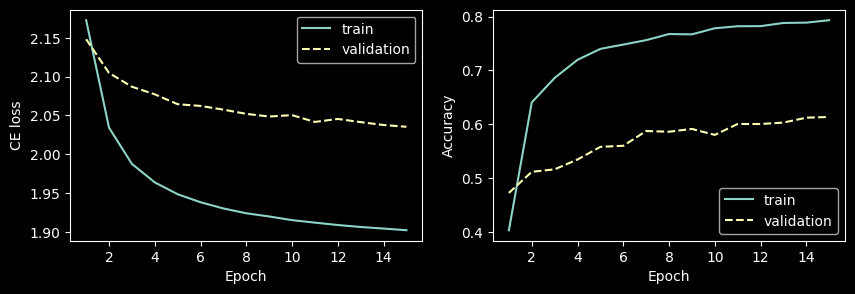

In [119]:
# learning curve
fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(range(1, n_epochs + 1), np.array(train_epochs_losses), label='train')
axs[0].plot(range(1, n_epochs + 1), np.array(val_epochs_losses), linestyle='dashed', label='validation')

axs[1].plot(range(1, n_epochs + 1), train_epochs_acc, label='train')
axs[1].plot(range(1, n_epochs + 1), val_epochs_acc, linestyle='dashed', label='validation')

axs[0].set_ylabel(loss_func_name)
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()

plt.show()

#### Trained masks

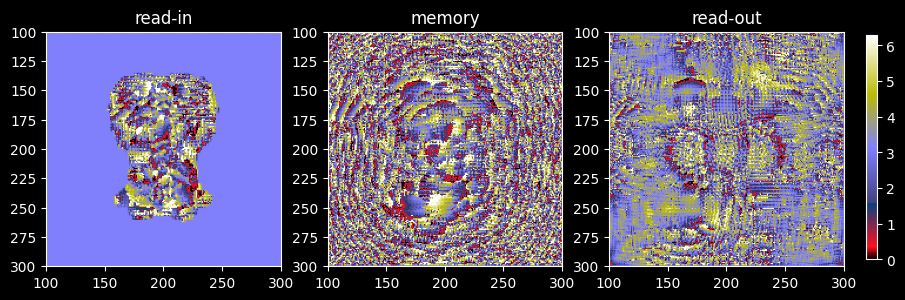

In [120]:
n_cols = 3  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3 + 2, n_rows * 3.2))
ind_diff_layer = 0

cmap = 'gist_stern'  # 'gist_stern' 'rainbow'

for ind_module, module in enumerate(
    [dai_rnn.read_in_layer, dai_rnn.memory_layer, dai_rnn.read_out_layer]
):
    titles = ['read-in', 'memory', 'read-out']
    
    for ind_layer, layer in enumerate(module):
        if isinstance(layer, elements.DiffractiveLayer):  # plot masks for Diffractive layers
            if n_rows > 1:
                ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
            else:
                ax_this = axs[ind_diff_layer % n_cols]
    
            ax_this.set_title(titles[ind_module])
    
            trained_mask = layer.mask.detach()
            
            phase_mask_this = ax_this.imshow(         
                trained_mask, cmap=cmap,
                vmin=0, vmax=MAX_PHASE
            )
            ind_diff_layer += 1
    
            if APERTURES:  # select only a part within apertures!
                x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
                y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
                ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.01, 0.7])
plt.colorbar(phase_mask_this, cax=cbar_ax)

plt.show()

#### Saving results

In [121]:
# array with all losses
all_lasses_header = ','.join([
    f'{loss_func_name.split()[0]}_train', f'{loss_func_name.split()[0]}_val',
    'accuracy_train', 'accuracy_val'
])
all_losses_array = np.array(
    [train_epochs_losses, val_epochs_losses, train_epochs_acc, val_epochs_acc]
).T

In [122]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/recurrent_net.pth'
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

#### Saving model weights and learning curves

In [123]:
# saving model
# torch.save(dai_rnn.state_dict(), model_filepath)

In [124]:
# saving losses
# np.savetxt(
#     losses_filepath, all_losses_array,
#     delimiter=',', header=all_lasses_header, comments=""
# )

## 4.3. Predicting video class by averaging predictions for all sub-sequences

### 4.3.1. Function that splits a video into sub-sequences and returns predictions

In [125]:
def predict_video(net, masks_filepath, flip=True, show_process=True):

    action_name = masks_filepath.split('/')[2].split('_')[0]  # depends on a data directory!
    label = ACTION_TO_ID[action_name]  # label for the sequence
    
    file_seqs_ds = WeizmannDsWfSeqs(
        [masks_filepath],
        transforms_for_ds,
        SIM_PARAMS,
        augmentation_horizontally_flip=flip,
        target='detector',
        detector_mask=DETECTOR_MASK,
    )  # item: (image wavefront, target detector tensor, label)

    # sum of all detector images for each sequence of the video
    detector_image = torch.zeros(
        size = SIM_PARAMS.axes_size(
            axs=('H', 'W')
        )
    )
    seqs_pred_labels = []

    if flip:# sum of all detector images for each flipped squence of the video
        flipped_detector_image = torch.zeros(
            size = SIM_PARAMS.axes_size(
                axs=('H', 'W')
            )
        )
        flipped_seqs_pred_labels = []

    ind_this = 0
    for seq_wavefronts, seq_target, seq_label in tqdm(file_seqs_ds, disable=not show_process):
        
        net.eval()  # pedict sequence:
        with torch.no_grad():
            seq_detector = net(seq_wavefronts)
            if flip:
                if ind_this % 2 == 0:  # not flipped sequence
                    detector_image += seq_detector
                else:  # flipped sequence
                    flipped_detector_image += seq_detector
            else:
                detector_image += seq_detector
    
            # process a detector image
            if detector_processor:
                pred_label_this = detector_processor.forward(detector_image).argmax().item()  # predicted label
                
                if flip:
                    if ind_this % 2 == 0:  # not flipped sequence
                        seqs_pred_labels.append(pred_label_this)
                    else:  # flipped sequence
                        flipped_seqs_pred_labels.append(pred_label_this)
                else:
                    seqs_pred_labels.append(pred_label_this)

        ind_this +=1
    if flip:
        return detector_image + flipped_detector_image, seqs_pred_labels, flipped_seqs_pred_labels, label
    else:
        return detector_image, seqs_pred_labels, label

### 4.3.2. Example of predicting one file

In [126]:
test_filepath = all_test_files[22]  # select any filepath from test set
test_filename = test_filepath.split('/')[-1]

use_flipped_seqs = True  # using horizontal flip to predict file or not

print(test_filename)

ira_walk.npy


In [127]:
# predicting a file by all subsequences
detector_sum, labels_by_seqs, labels_by_flipped_seqs, label_0 = predict_video(
    dai_rnn, test_filepath, flip=True
)

100%|██████████████████████████████████████████████████████| 162/162 [00:06<00:00, 24.45it/s]


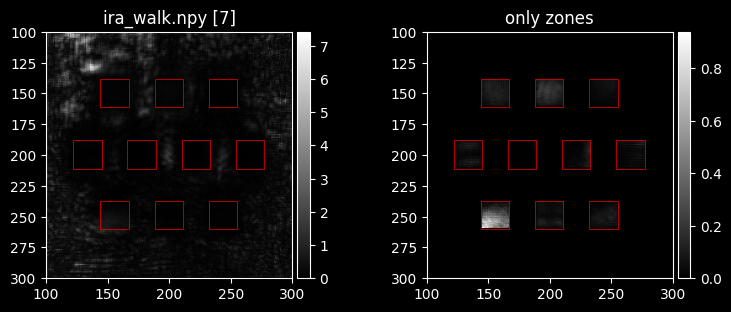

In [128]:
# plot detector images sum for a video
fig, axs = plt.subplots(1, 2, figsize=(3 * 3, 3.2))
cmap = 'grey'

ax_this = axs[0]
ax_this.set_title(f'{test_filename} [{label_0}]')
img = ax_this.imshow(detector_sum, cmap=cmap)
# colorbar
divider = make_axes_locatable(ax_this)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax, orientation='vertical')


ax_this = axs[1]
ax_this.set_title('only zones')
detector_zones_selection_mask = torch.where(DETECTOR_MASK > -1, 1.0, 0.0)
img = ax_this.imshow(detector_sum * detector_zones_selection_mask, cmap=cmap)
# colorbar
divider = make_axes_locatable(ax_this)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(img, cax=cax, orientation='vertical')

for ax_this in axs:
    for zone in get_zones_patches(DETECTOR_MASK):
        # add zone's patches to the axis
        # zone_copy = copy(zone)
        ax_this.add_patch(zone)

    if APERTURES:  # select only a part within apertures!
        x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
        y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
        ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])
    
plt.show()

In [129]:
if detector_processor:
    for label, proba in enumerate(detector_processor.forward(detector_sum)[0]):
        print(f'{ID_TO_ACTION[label]}:\t{proba * 100:.2f}%')

bend:	9.93%
jack:	13.18%
jump:	6.26%
pjump:	6.38%
run:	2.02%
side:	6.82%
skip:	6.55%
walk:	36.73%
wave1:	5.76%
wave2:	6.36%


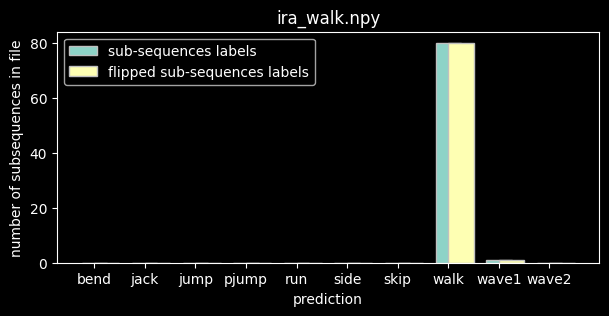

In [130]:
fig, ax0 = plt.subplots(1, 1, figsize=(7, 3))
bars_width = 0.5
bars_shift = 0.25

ax0.hist(
    labels_by_seqs, bins=list(range(NUM_ACTIONS + 1)),
    align='left', rwidth=bars_width, label='sub-sequences labels',
    edgecolor='silver'
)

ax0.hist(
    np.array(labels_by_flipped_seqs) + bars_shift, 
    bins=np.arange(NUM_ACTIONS + 1) + bars_shift,
    align='left', rwidth=bars_width, label='flipped sub-sequences labels',
    edgecolor='silver'
)

# axes settings
ax0.set_title(test_filepath.split('/')[-1])

ax0.set_xticks(range(NUM_ACTIONS))
ax0.set_xticklabels([ID_TO_ACTION[ind] for ind in range(NUM_ACTIONS)])

ax0.set_ylabel('number of subsequences in file')
ax0.set_xlabel('prediction')

# ax0.set_ylim([0, 1000])

ax0.legend()
plt.show()

### 4.3.3. Prediction all test files

In [131]:
NUM_TEST_FILES = len(all_test_files)

In [132]:
# confusion matrix
# prediction by subsequences labels
confusion_matrix_top_seqs = torch.zeros(size=(len(all_test_files), NUM_ACTIONS), dtype=torch.int32)

# predictions by detector probas
confusion_matrix_detector = torch.zeros(size=(len(all_test_files), NUM_ACTIONS), dtype=torch.float32)

In [133]:
true_predictions = 0
false_predictions = 0

use_flipped_seqs = True  # using horizontal flip to predict file or not

top_length = 3  # check top 3 predictions
in_top = 0

for ind_file, filepath in enumerate(tqdm(all_test_files)):
    if use_flipped_seqs:
        detector_1, pred_labels_1, pred_labels_2, true_label = predict_video(
            dai_rnn, filepath, flip=True, show_process=False
        )
    else:
        detector_1, pred_labels_1, true_label = predict_video(
            dai_rnn, filepath, flip=True, show_process=False
        )

    # ind_file must be connected with label!
    # all_test_files is sorted by actions!

    if use_flipped_seqs:
        counter_preds = Counter(pred_labels_1 + pred_labels_2)
    else:
        counter_preds = Counter(pred_labels_1)
    # update confusion matrix
    confusion_matrix_top_seqs[ind_file, :] = torch.tensor([counter_preds[label] for label in range(NUM_ACTIONS)])
    
    # is the true prediction in top N?
    top_preds = counter_preds.most_common(top_length)
    for pred, _ in top_preds:
        if pred == true_label:
            in_top += 1
            break
    
    if detector_processor:
        probas = detector_processor.forward(
            detector_1
        )[0]
        predicted_label = probas.argmax().item()

    confusion_matrix_detector[ind_file, :] = probas  # update confusion matrix
    
    if predicted_label == true_label:
        true_predictions += 1
    else:
        false_predictions += 1

print(f'Files prediction accuracy: {true_predictions / (true_predictions + false_predictions) * 100 :.2f}%')
print(f'True label in top-{top_length} predictions for {in_top} out of {len(all_test_files)} test files')

100%|████████████████████████████████████████████████████████| 30/30 [02:01<00:00,  4.05s/it]

Files prediction accuracy: 80.00%
True label in top-3 predictions for 25 out of 30 test files


In [134]:
with open(f'{RESULTS_FOLDER}/results.txt', 'w') as file:
    # training results
    file.write(f'Training results ({n_epochs} epochs):\n')
    file.write(f'\tTrain: {train_epochs_acc[-1] * 100:.2f}%\n')
    file.write(f'\tTest: {val_epochs_acc[-1] * 100:.2f}%\n')

    file.write('\nPerfomance:\n')
    # write perfomance results
    file.write(f'\tFiles prediction accuracy: {true_predictions / (true_predictions + false_predictions) * 100 :.2f}%\n')
    file.write(f'\tTrue label in top-{top_length} predictions for {in_top} out of {len(all_test_files)} test files!')


#### Plot confusion matrices

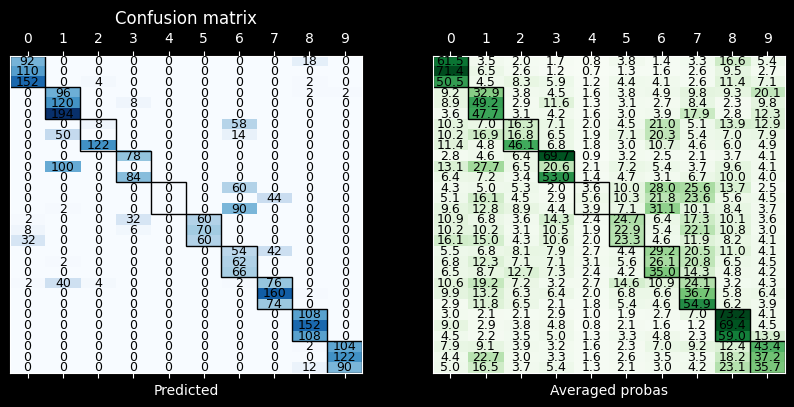

In [135]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

# CONFUSION MATRIX
ax0.set_title('Confusion matrix')
ax0.matshow(confusion_matrix_top_seqs, cmap='Blues')

for i in range(NUM_ACTIONS):
    for j in range(NUM_TEST_FILES):
        val = confusion_matrix_top_seqs[j, i].item()
        ax0.text(
            i, j, str(val),
            va='center', ha='center', 
            c='k', fontsize=9
        )

# ax0.set_ylabel('Target')
ax0.set_xlabel('Predicted')

ax0.set_xticks(range(NUM_ACTIONS))
ax0.set_yticks([])  # (range(NUM_TEST_FILES))
ax0.set_aspect(0.3)

# AVERAGED PREDICTED PROBAS
# ax1.set_title('Averaged confidences')
ax1.matshow(confusion_matrix_detector, cmap='Greens')

for i in range(NUM_ACTIONS):
    for j in range(NUM_TEST_FILES):
        val = confusion_matrix_detector[j, i].item()
        ax1.text(
            i, j, f'{val * 100:.1f}',
            va='center', ha='center', 
            c='k', fontsize=9
        )

delta = 1
for ax_this in (ax0, ax1):
    delta = 0.5
    
    ind_file = 0
    n_files_per_class = 3
    
    for ind_class in range(NUM_ACTIONS):        
        zone_rect = patches.Rectangle(
            (ind_class - delta, ind_file - delta), 
            1, n_files_per_class, 
            linewidth=1, 
            edgecolor='k',
            facecolor='none'
        )
        ind_file += n_files_per_class
        ax_this.add_patch(zone_rect)
        
ax1.set_xlabel('Averaged probas')

ax1.set_xticks(range(NUM_ACTIONS))
ax1.set_yticks([])
ax1.set_aspect(0.3)

# ax1.set_yticks(range(number_of_classes), labels=['' for _ in range(number_of_classes)])

plt.show()

# save figure
fig.savefig(f'{RESULTS_FOLDER}/confusion_matrix.png', bbox_inches='tight')

In [136]:
ID_TO_ACTION

{0: 'bend',
 1: 'jack',
 2: 'jump',
 3: 'pjump',
 4: 'run',
 5: 'side',
 6: 'skip',
 7: 'walk',
 8: 'wave1',
 9: 'wave2'}